In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!unzip "/content/drive/MyDrive/Final Thesis/chest-x-ray.zip" -d "/content/tmp"

In [1]:
import os
import tensorflow as tf
import numpy as np
import imgaug as aug
from pathlib import Path
from glob import glob
from enum import Enum
import cv2
from torch.utils.data import Dataset
from threading import Thread
import time
import random
import matplotlib.pyplot as plt
import imgaug.augmenters as iaa
import numpy as np

from sklearn.ensemble import  ExtraTreesClassifier

from keras import backend as K
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Sequential
from tensorflow.keras.callbacks import ReduceLROnPlateau
from tensorflow.keras.layers import Conv2D, Activation, MaxPool2D, Flatten, Dense, Dropout, BatchNormalization, MaxPooling2D
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import MobileNet

from sklearn.metrics import classification_report
from mlxtend.plotting import plot_confusion_matrix
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_curve, roc_auc_score
from sklearn.metrics import accuracy_score


In [2]:
# Set the seed for hash based operations in python
os.environ['PYTHONHASHSEED'] = '0'

# Set the numpy seed
np.random.seed(111)

# Disable multi-threading in tensorflow ops
session_conf = tf.compat.v1.ConfigProto(intra_op_parallelism_threads=1, inter_op_parallelism_threads=1)

# Set the random seed in tensorflow at graph level
tf.random.set_seed(111)

# Define a tensorflow session with above session configs
sess = tf.compat.v1.Session(graph=tf.compat.v1.get_default_graph(), config=session_conf)

# Set the session in keras
K.set_session(sess)

# Make the augmentation sequence deterministic
aug.seed(111)

In [3]:
!nvidia-smi

Wed Apr 26 22:28:07 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.85.12    Driver Version: 525.85.12    CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   72C    P0    32W /  70W |    373MiB / 15360MiB |      5%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [4]:
#DATASET_PATH = '/content/tmp/chest_xray'
DATASET_PATH = 'tmp/chest_xray'
RESIZED_IMAGE_SIZE = 224

class DatasetType(Enum):
    TRAIN = 'train'
    TEST = 'test'
    VAL = 'val'
    
class DataType(Enum):
    NORMAL = 0
    PNEUMONIA = 1
    
class ImageType(Enum):
    ORIGINAL = 'original'
    AUGMENTED = 'augmented'

In [5]:
class ChestXRayDataset (Dataset):

    def __init__ (self, dataset_type=DatasetType.TRAIN, num_samples=None, original_img_probability=0.1):
        
        self.dataset_type = dataset_type
        self.original_img_probability = original_img_probability
        self.num_samples = num_samples
        
        self.seq = iaa.OneOf([
            iaa.Affine(rotate=(-10, 10)),
            iaa.Affine(scale=(0.9, 1.1)),
            iaa.Affine(shear=(-10, 10)),
            iaa.TranslateX(percent=(-0.1, 0.1)),
            iaa.TranslateY(percent=(-0.1, 0.1)),
            iaa.Multiply((1.2, 1.5))]) #random brightness

        x_normal, x_penumonia = [], []
        x_normal_path, x_normal_type = self.__get_image_paths (dataset_type, DataType.NORMAL)
        x_pneumonia_path, x_pneumonia_type = self.__get_image_paths (dataset_type, DataType.PNEUMONIA)
        
        t1 = Thread (target=self.__load_images, args=(x_normal_path, x_normal_type, x_normal,))
        t2 = Thread (target=self.__load_images, args=(x_pneumonia_path, x_pneumonia_type, x_penumonia,))
        
        start_time = time.time()
        t1.start (), t2.start ()
        t1.join (), t2.join ()
        
        self.x_data = np.expand_dims(x_normal + x_penumonia, axis=-1)
        self.y_data = [ DataType.NORMAL.value ] * len (x_normal) + [ DataType.PNEUMONIA.value ] * len (x_penumonia)
        self.y_data = to_categorical (self.y_data, num_classes=2)
        
        del x_normal
        del x_penumonia
        del x_normal_path
        del x_normal_type
        del x_pneumonia_path
        del x_pneumonia_type
        print (f'Total time for loading {str(dataset_type.value)} images: {time.time() - start_time}')
        
    
    def get_data (self):
        return np.repeat(self.x_data[...], 3, -1), self.y_data
        
    
    def __get_image_paths (self, dataset_type: DatasetType, data_type: DataType):
        img_paths = glob(DATASET_PATH + '/' + str(dataset_type.value) + '/' + str(data_type.name) + '/*.jpeg', recursive=False)
        
        if self.num_samples != None and dataset_type == DatasetType.TRAIN:      
            if len (img_paths) > self.num_samples:
                img_paths = random.sample (img_paths, self.num_samples)
        img_types = [ImageType.ORIGINAL] * len(img_paths)
        
        if self.num_samples != None and dataset_type == DatasetType.TRAIN:  
            if len(img_paths) < self.num_samples:
                samples_num_to_augment = self.num_samples - len(img_paths)
                img_paths.extend (random.choices (img_paths, k=(samples_num_to_augment)))
                img_types.extend([ImageType.AUGMENTED] * (samples_num_to_augment))
        
        return img_paths, img_types
    
    def __read_preprocessed_image (self, img_path):
        img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
        img = cv2.resize(img, (RESIZED_IMAGE_SIZE, RESIZED_IMAGE_SIZE), interpolation=cv2.INTER_CUBIC)
        img = img.astype(np.float32)/255.
        return img
    
    
    def __load_images (self, img_paths, image_types, result):
        for (img_path, image_type) in zip (img_paths, image_types):
            try:
                if image_type == ImageType.AUGMENTED:
                    if random.choices ([ImageType.ORIGINAL, ImageType.AUGMENTED], [self.original_img_probability, 1-self.original_img_probability])[0] == ImageType.AUGMENTED:
                        result.append (self.seq.augment_image(self.__read_preprocessed_image(img_path)))
                    else:
                        result.append (self.__read_preprocessed_image(img_path))
                else:
                    result.append (self.__read_preprocessed_image(img_path))
            except Exception as e:
                print (e)

    
    def __getitem__ (self, index):
        return self.x_data[index], self.y_data[index]
        

    def __len__ (self):
        return len (self.y_data)

In [6]:
x_train, y_train = ChestXRayDataset (DatasetType.TRAIN).get_data ()
print ('Train dataset size:', len(x_train))

x_test, y_test = ChestXRayDataset (DatasetType.TEST).get_data ()
print ('Test dataset size:', len(x_test))

val_data = ChestXRayDataset (DatasetType.VAL).get_data ()
print ('Valid dataset size:', len(val_data[0]))

Total time for loading train images: 46.756428718566895
Train dataset size: 5216
Total time for loading test images: 4.6703879833221436
Test dataset size: 624
Total time for loading val images: 0.1113121509552002
Valid dataset size: 16


In [8]:
datagen = ImageDataGenerator(
    rotation_range=10,
    zoom_range = 0.1,
    width_shift_range=0.1,
    height_shift_range=0.1,
    horizontal_flip=False,
    vertical_flip=False
)

# fit generator on our train features
datagen.fit(x_train)

In [9]:
print('Train data shape:', x_train.shape)
print('Train labels size:', y_train.shape)

Train data shape: (5216, 196, 196, 3)
Train labels size: (5216, 2)


/usr/local/lib/python3.9/dist-packages/matplotlib/text.py:1279: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if s != self._text:


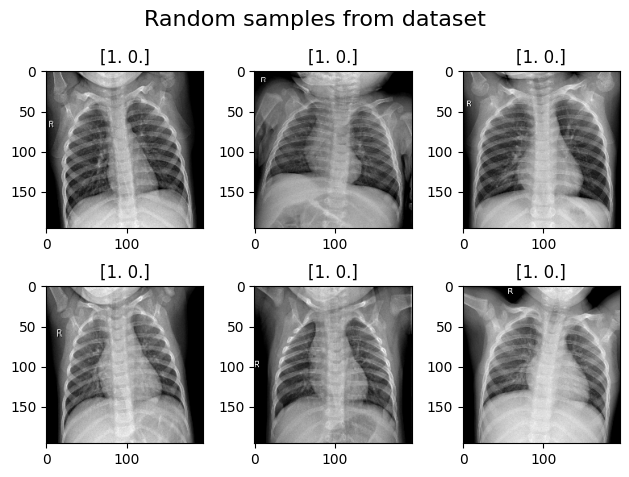

In [10]:
plt.rcParams.update(plt.rcParamsDefault)
for i in range (6):
    plt.suptitle("Random samples from dataset", fontsize=16)
    ax = plt.subplot (2, 3, i+1)
    plt.imshow (x_train[i], cmap='gray')
    ax.set_title(y_train[i])
    plt.tight_layout()
plt.show ()

In [22]:
MODEL_NAME = 'CompactMedNet'
def create_model ():

    model = Sequential()

    model.add(Conv2D(16, (3, 3), activation='relu', padding="same", input_shape=(RESIZED_IMAGE_SIZE, RESIZED_IMAGE_SIZE, 1)))
    model.add(Conv2D(16, (3, 3), padding="same", activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))

    model.add(Conv2D(32, (3, 3), activation='relu', padding="same"))
    model.add(Conv2D(32, (3, 3), padding="same", activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))

    model.add(Conv2D(64, (3, 3), activation='relu', padding="same"))
    model.add(Conv2D(64, (3, 3), padding="same", activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))

    model.add(Conv2D(96, (3, 3), dilation_rate=(2, 2), activation='relu', padding="same"))
    model.add(Conv2D(96, (3, 3), padding="valid", activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))

    model.add(Conv2D(128, (3, 3), dilation_rate=(2, 2), activation='relu', padding="same"))
    model.add(Conv2D(128, (3, 3), padding="valid", activation='relu'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=(2, 2)))

    model.add(Flatten())

    model.add(Dense(128, activation='relu'))
    model.add(Dropout(0.2))
    model.add(Dense(64, activation='relu'))
    model.add(Dropout(0.2))
    model.add(Dense(32, activation='relu'))
    model.add(Dropout(0.2))
    model.add(Dense(2, activation='softmax'))
    return model

model = create_model ()
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_10 (Conv2D)          (None, 196, 196, 16)      160       
                                                                 
 conv2d_11 (Conv2D)          (None, 196, 196, 16)      2320      
                                                                 
 max_pooling2d_5 (MaxPooling  (None, 98, 98, 16)       0         
 2D)                                                             
                                                                 
 conv2d_12 (Conv2D)          (None, 98, 98, 32)        4640      
                                                                 
 conv2d_13 (Conv2D)          (None, 98, 98, 32)        9248      
                                                                 
 max_pooling2d_6 (MaxPooling  (None, 49, 49, 32)       0         
 2D)                                                  

In [13]:
MODEL_NAME = 'MobileNet'
def create_model ():

    pretrained_model=MobileNet(weights='imagenet', include_top=False,input_shape=(RESIZED_IMAGE_SIZE,RESIZED_IMAGE_SIZE,3))
    
    #train the model
    tf.random.set_seed(45)
    model = pretrained_model.output
    model = tf.keras.layers.GlobalAveragePooling2D()(model)
    model = tf.keras.layers.Dense(64,activation='elu',kernel_initializer='GlorotNormal')(model)
    model = tf.keras.layers.Dropout(rate=0.2)(model)
    model = tf.keras.layers.Dense(4,activation='softmax')(model)
    model = tf.keras.models.Model(inputs=pretrained_model.input, outputs = model)

    return model

model = create_model ()
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 196, 196, 3)]     0         
                                                                 
 conv1 (Conv2D)              (None, 98, 98, 32)        864       
                                                                 
 conv1_bn (BatchNormalizatio  (None, 98, 98, 32)       128       
 n)                                                              
                                                                 
 conv1_relu (ReLU)           (None, 98, 98, 32)        0         
                                                                 
 conv_dw_1 (DepthwiseConv2D)  (None, 98, 98, 32)       288       
                                                                 
 conv_dw_1_bn (BatchNormaliz  (None, 98, 98, 32)       128       
 ation)                                                      

In [44]:
BATCH_SIZE = 32
LEARNING_RATE = 0.0001
NUM_EPOCH = 40

In [45]:
model.compile(optimizer = Adam(learning_rate=0.0001), 
                loss = 'categorical_crossentropy',
                metrics = ['accuracy'])

In [46]:
#weight_path="/content/tmp/{}.best.hdf5".format(MODEL_NAME)
weight_path="tmp/{}.best.hdf5".format(MODEL_NAME)

checkpoint = ModelCheckpoint(weight_path, monitor='val_loss', verbose=1, 
                             save_best_only=True, mode='min', save_weights_only = True)

reduceLROnPlat = ReduceLROnPlateau(monitor='val_loss', factor=0.1, 
                              patience=10, verbose=1, mode='auto', 
                              min_delta=0.02, cooldown=5, min_lr=0.000001)
early = EarlyStopping(monitor="loss", 
                      mode="min",
                      min_delta=0.01,
                      patience=6)
callbacks_list = [checkpoint, early]

In [ ]:
history = model.fit(datagen.flow(x_train,y_train, batch_size=4),
                    epochs = 100,
                    shuffle=True,
                    verbose=1,
                    validation_data=val_data,
                    callbacks=callbacks_list)

In [14]:
trained_model = create_model ()
trained_model.load_weights ('tmp/' + MODEL_NAME + '.best.hdf5')
y_pred = trained_model.predict(x_test)

20/20 [==============================] - 7s 34ms/step


In [49]:
print(classification_report(np.argmax(y_pred, axis = 1),np.argmax(y_test, axis = 1)))

              precision    recall  f1-score   support

           0       0.87      0.97      0.92       209
           1       0.98      0.93      0.95       415

    accuracy                           0.94       624
   macro avg       0.93      0.95      0.94       624
weighted avg       0.95      0.94      0.94       624



In [51]:
accuracy_score(np.argmax(y_test, axis = 1), np.argmax(y_pred, axis = 1))

0.9407051282051282

<Figure size 640x480 with 0 Axes>

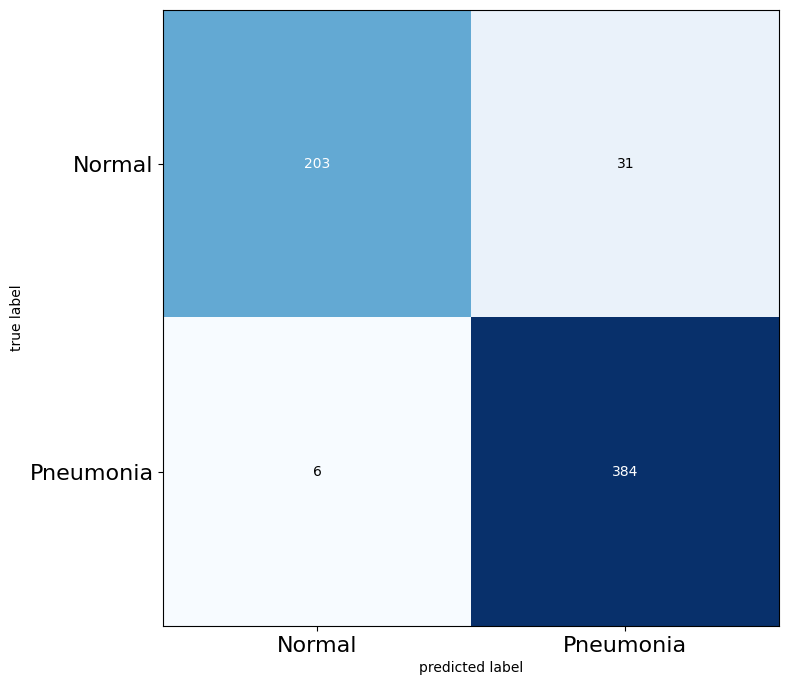

In [50]:
cm  = confusion_matrix(np.argmax(y_test, axis = 1), np.argmax(y_pred, axis = 1))
plt.figure()
plot_confusion_matrix(cm,figsize=(12,8), hide_ticks=True,cmap=plt.cm.Blues)
plt.xticks(range(2), ['Normal', 'Pneumonia'], fontsize=16)
plt.yticks(range(2), ['Normal', 'Pneumonia'], fontsize=16)
plt.show()

cnn4
149 85
1   383

In [ ]:
tn, fp, fn, tp = cm.ravel()

precision = tp/(tp+fp)
recall = tp/(tp+fn)

print("Recall of the model is {:.2f}".format(recall))
print("Precision of the model is {:.2f}".format(precision))

Recall of the model is 0.96
Precision of the model is 0.89


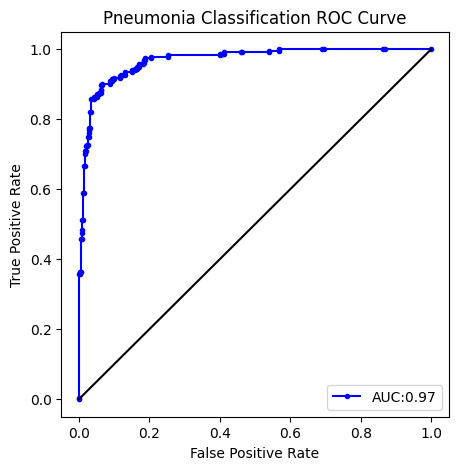

In [ ]:
fpr, tpr, _ = roc_curve(np.argmax(y_test,-1)==0, y_pred[:,0])
fig, ax1 = plt.subplots(1,1, figsize = (5, 5), dpi = 100)
ax1.plot(fpr, tpr, 'b.-', label = 'AUC:%2.2f' % roc_auc_score(np.argmax(y_test,-1)==0, y_pred[:,0]))
ax1.plot(fpr, fpr, 'k-')
ax1.legend(loc = 4)
ax1.set_xlabel('False Positive Rate')
ax1.set_ylabel('True Positive Rate');
ax1.set_title('Pneumonia Classification ROC Curve')
plt.show()

In [15]:
feature_extractor = create_model ()
feature_extractor.load_weights ('tmp/' + MODEL_NAME + '.best.hdf5')
feature_extractor.summary()

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 196, 196, 3)]     0         
                                                                 
 conv1 (Conv2D)              (None, 98, 98, 32)        864       
                                                                 
 conv1_bn (BatchNormalizatio  (None, 98, 98, 32)       128       
 n)                                                              
                                                                 
 conv1_relu (ReLU)           (None, 98, 98, 32)        0         
                                                                 
 conv_dw_1 (DepthwiseConv2D)  (None, 98, 98, 32)       288       
                                                                 
 conv_dw_1_bn (BatchNormaliz  (None, 98, 98, 32)       128       
 ation)                                                    

In [16]:
from tensorflow.keras.models import Sequential, Model
new_input = feature_extractor.input
# Find the layer to connect
hidden_layer = feature_extractor.layers[-4].output
# Connect a new layer on it
#new_output = Dense(3) (hidden_layer)
# Build a new model
model2 = Model(new_input, hidden_layer)
model2.summary()

Model: "model_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 196, 196, 3)]     0         
                                                                 
 conv1 (Conv2D)              (None, 98, 98, 32)        864       
                                                                 
 conv1_bn (BatchNormalizatio  (None, 98, 98, 32)       128       
 n)                                                              
                                                                 
 conv1_relu (ReLU)           (None, 98, 98, 32)        0         
                                                                 
 conv_dw_1 (DepthwiseConv2D)  (None, 98, 98, 32)       288       
                                                                 
 conv_dw_1_bn (BatchNormaliz  (None, 98, 98, 32)       128       
 ation)                                                    

In [17]:
features_train = model2.predict(x_train)
features_test = model2.predict(x_test)

20/20 [==============================] - 1s 26ms/step


In [58]:
from sklearn.neighbors import KNeighborsClassifier
clf = KNeighborsClassifier(8)
clf.fit (features_train, np.argmax(y_train, axis = 1))

KNeighborsClassifier(n_neighbors=8)

In [18]:
clf = ExtraTreesClassifier(n_estimators=80, max_depth=2, random_state=111, class_weight={0:0.41, 1:0.59})
clf.fit (features_train, np.argmax(y_train, axis = 1))

ExtraTreesClassifier(class_weight={0: 0.41, 1: 0.59}, max_depth=2,
                     n_estimators=80, random_state=111)

In [20]:
clf_prediction = clf.predict(features_test)

In [21]:
print(classification_report(clf_prediction, np.argmax(y_test, axis = 1)))

              precision    recall  f1-score   support

           0       0.00      0.00      0.00         0
           1       1.00      0.62      0.77       624

    accuracy                           0.62       624
   macro avg       0.50      0.31      0.38       624
weighted avg       1.00      0.62      0.77       624



/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


<Figure size 640x480 with 0 Axes>

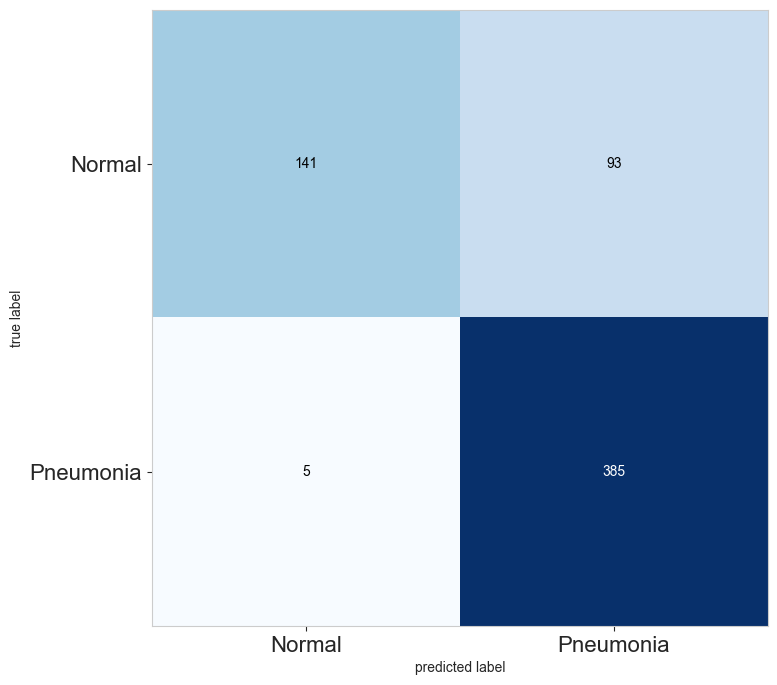

In [ ]:
cm  = confusion_matrix(np.argmax(y_test, axis = 1), clf_prediction)
plt.figure()
plot_confusion_matrix(cm,figsize=(12,8), hide_ticks=True,cmap=plt.cm.Blues)
plt.xticks(range(2), ['Normal', 'Pneumonia'], fontsize=16)
plt.yticks(range(2), ['Normal', 'Pneumonia'], fontsize=16)
plt.show()

In [ ]:
tn, fp, fn, tp = cm.ravel()

precision = tp/(tp+fp)
recall = tp/(tp+fn)

print("Recall of the model is {:.2f}".format(recall))
print("Precision of the model is {:.2f}".format(precision))

Recall of the model is 0.97
Precision of the model is 0.80


Fitting 5 folds for each of 100 candidates, totalling 500 fits
[CV 1/5] END .....class_weight={0: 0.0, 1: 1.0};, score=0.667 total time=   0.1s
[CV 4/5] END .....class_weight={0: 0.0, 1: 1.0};, score=0.667 total time=   0.1s
[CV 3/5] END .....class_weight={0: 0.0, 1: 1.0};, score=0.667 total time=   0.1s
[CV 2/5] END .....class_weight={0: 0.0, 1: 1.0};, score=0.667 total time=   0.1s
[CV 5/5] END .....class_weight={0: 0.0, 1: 1.0};, score=0.667 total time=   0.1s
[CV 1/5] END ...class_weight={0: 0.01, 1: 0.99};, score=0.668 total time=   1.3s
[CV 2/5] END ...class_weight={0: 0.01, 1: 0.99};, score=0.676 total time=   1.4s
[CV 3/5] END ...class_weight={0: 0.01, 1: 0.99};, score=0.685 total time=   1.4s
[CV 5/5] END ...class_weight={0: 0.01, 1: 0.99};, score=0.683 total time=   1.4s
[CV 1/5] END ...class_weight={0: 0.02, 1: 0.98};, score=0.672 total time=   1.5s
[CV 2/5] END ...class_weight={0: 0.02, 1: 0.98};, score=0.684 total time=   1.5s
[CV 3/5] END ...class_weight={0: 0.02, 1: 0.98

Text(0.5, 1.0, 'Scoring for different class weights')

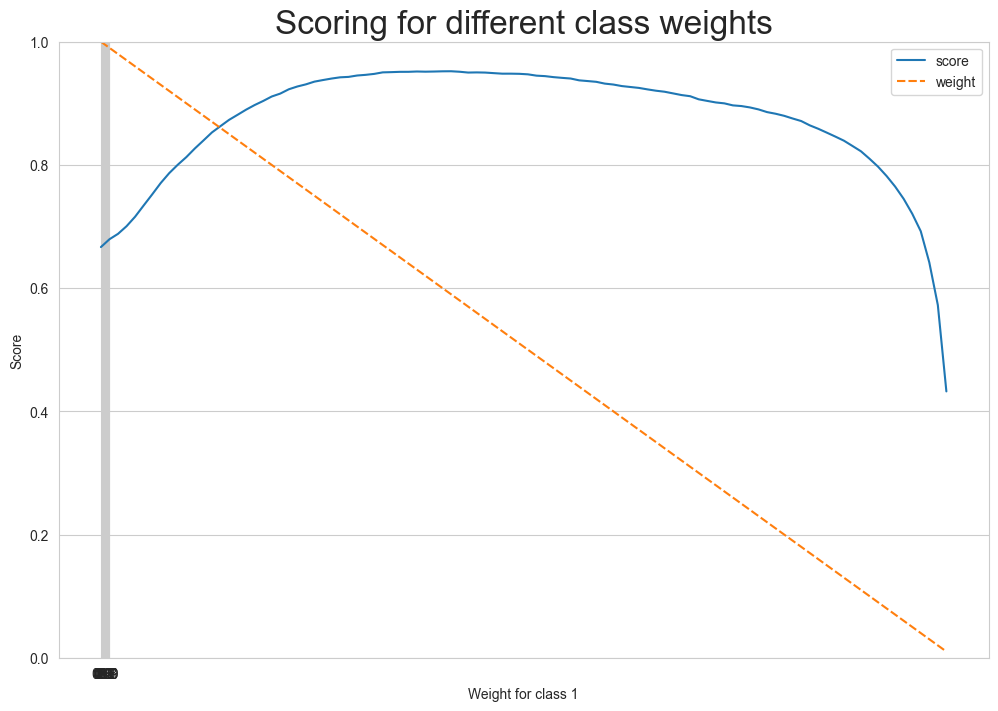

In [ ]:
from sklearn.model_selection import GridSearchCV, StratifiedKFold
from sklearn.linear_model import LogisticRegression
import seaborn as sns
import pandas as pd

lr = ExtraTreesClassifier(n_estimators=80, max_depth=2, random_state=111)

#Setting the range for class weights
weights = np.linspace(0.0,0.99,100)

#Creating a dictionary grid for grid search
param_grid = {'class_weight': [{0:x, 1:1.0-x} for x in weights]}

#Fitting grid search to the train data with 5 folds
gridsearch = GridSearchCV(estimator= lr, 
                          param_grid= param_grid,
                          cv=StratifiedKFold(), 
                          n_jobs=-1, 
                          scoring='f1', 
                          verbose=3).fit(features_train, np.argmax(y_train, axis = 1))

#Ploting the score for different values of weight
sns.set_style('whitegrid')
plt.figure(figsize=(12,8))
weigh_data = pd.DataFrame({ 'score': gridsearch.cv_results_['mean_test_score'], 'weight': (1.0- weights)})
sns.lineplot(weigh_data)
plt.xlabel('Weight for class 1')
plt.ylabel('Score')
plt.xticks([round(i/10,1) for i in range(0,11,1)])
plt.ylim([0, 1])
plt.title('Scoring for different class weights', fontsize=24)

In [ ]:
print(np.where(weigh_data['score'] == np.amax(weigh_data['score'])))
print(np.amax(weigh_data['score']))

(array([41]),)
0.9520662382285717
